In [79]:
# Standard libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

# Open3D for point cloud processing
import open3d as o3d

In [80]:
# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

In [95]:
def build_kdtree(data):
    """
    Build a KDTree from the given data.
    
    Parameters:
        data (np.ndarray): Data points for the KDTree.
        
    Returns:
        cKDTree: Constructed KDTree.
    """
    tree = cKDTree(data)
    return tree

def extract_rgb(pcd):
    """
    Extract RGB values from a point cloud.
    
    Parameters:
        pcd (o3d.geometry.PointCloud): Input point cloud.
        
    Returns:
        np.ndarray: Array of RGB values normalized between 0 and 1.
    """
    if not pcd.has_colors():
        raise ValueError("Point cloud does not have color information.")
    rgb = np.asarray(pcd.colors)
    return rgb

def extract_xyz(pcd):
    """
    Extract XYZ coordinates from a point cloud.
    
    Parameters:
        pcd (o3d.geometry.PointCloud): Input point cloud.
        
    Returns:
        np.ndarray: Array of XYZ coordinates.
    """
    xyz = np.asarray(pcd.points)
    return xyz

def assign_labels_with_rgb_spatial_height(combined_rgb, combined_xyz, plant_rgb, plant_xyz, 
                                         rgb_tolerance=0.01, spatial_tolerance=0.05, z_min=None, z_max=None):
    """
    Assign labels to points in the combined point cloud based on RGB, spatial proximity, and relative height.
    
    Parameters:
        combined_rgb (np.ndarray): RGB array of the combined point cloud (N x 3), values in [0, 1].
        combined_xyz (np.ndarray): XYZ coordinates of the combined point cloud (N x 3).
        plant_rgb (np.ndarray): RGB array of the plant-only point cloud (M x 3), values in [0, 1].
        plant_xyz (np.ndarray): XYZ coordinates of the plant-only point cloud (M x 3).
        rgb_tolerance (float): Maximum Euclidean distance in RGB space to consider a point as plant.
        spatial_tolerance (float): Maximum spatial distance to consider proximity to plant points.
        z_min (float): Minimum Z-value (height) from plant-only point cloud.
        z_max (float): Maximum Z-value (height) from plant-only point cloud.
        
    Returns:
        np.ndarray: Labels array for the combined point cloud (N,), where 0 = plant, 1 = non-plant.
    """
    # Initialize all labels as non-plant (1)
    labels = np.ones(len(combined_rgb), dtype=np.int32)
    
    # Build KDTree for RGB
    rgb_tree = build_kdtree(plant_rgb)
    
    # Query the nearest plant RGB for each combined RGB
    rgb_distances, _ = rgb_tree.query(combined_rgb, k=1)
    
    # Assign labels based on RGB tolerance
    rgb_label_mask = rgb_distances <= rgb_tolerance
    labels[rgb_label_mask] = 0  # Tentatively label as plant
    
    # Build KDTree for spatial coordinates
    spatial_tree = build_kdtree(plant_xyz)
    
    # Query the nearest plant point for each combined point
    spatial_distances, _ = spatial_tree.query(combined_xyz, k=1)
    
    # Assign labels based on spatial tolerance
    spatial_label_mask = spatial_distances <= spatial_tolerance
    # Only keep labels as plant if both RGB and spatial conditions are met
    labels[np.logical_not(spatial_label_mask) & (labels == 0)] = 1  # Reassign to non-plant if spatial tolerance not met
    
    # Apply height constraints if z_min and z_max are provided
    if z_min is not None and z_max is not None:
        height_mask = (combined_xyz[:, 2] >= z_min) & (combined_xyz[:, 2] <= z_max)
        labels = np.where(height_mask, labels, 1)  # Set labels to 1 if outside height range
    
    return labels
def recolor_pcd_based_on_labels(pcd, labels):
    """
    Recolor the point cloud based on labels.
    
    Parameters:
        pcd (o3d.geometry.PointCloud): Labeled point cloud.
        labels (np.ndarray): Array of labels.
        
    Returns:
        o3d.geometry.PointCloud: Recolored point cloud.
    """
    # Define color mappings
    plant_color = [0, 1, 0]      # Green
    non_plant_color = [1, 0, 0]  # Red
    
    # Assign colors based on labels
    colors = np.array([plant_color if label == 0 else non_plant_color for label in labels])
    pcd.colors = o3d.utility.Vector3dVector(colors)
    
    return pcd

In [112]:
# Load a sample plant-only point cloud
plant_pcd_path = os.path.join(project_root, 'data', 'raw', 'plant_only', 'Wheat_Alsen_F0_2023-06-30-1949_fused_output.ply')

plant_pcd = o3d.io.read_point_cloud(plant_pcd_path)
print(f"Plant-only point cloud has {len(plant_pcd.points)} points.")

# Load a sample combined point cloud
combined_pcd_path = os.path.join(project_root, 'data', 'raw', 'combined', 'Wheat_Alsen_F0_2023-06-30-1949_fused_output.ply')
combined_pcd = o3d.io.read_point_cloud(combined_pcd_path)
print(f"Combined point cloud has {len(combined_pcd.points)} points.")

# Visualize plant-only point cloud
#o3d.visualization.draw_geometries([plant_pcd], window_name='Plant-Only Point Cloud')

# Visualize combined point cloud
#o3d.visualization.draw_geometries([combined_pcd], window_name='Combined Point Cloud')

Plant-only point cloud has 309087 points.
Combined point cloud has 1856179 points.


In [113]:
import copy
labeled_pcd = copy.deepcopy(combined_pcd)

In [114]:
# Extract RGB and XYZ
plant_rgb = extract_rgb(plant_pcd)
plant_xyz = extract_xyz(plant_pcd)
combined_rgb = extract_rgb(combined_pcd)
combined_xyz = extract_xyz(combined_pcd)

# Determine height boundaries from plant-only point cloud
z_min = plant_xyz[:, 2].min()
z_max = plant_xyz[:, 2].max()
print(f"Plant Height Range: Z_min = {z_min:.3f}, Z_max = {z_max:.3f}")
    
# Assign labels with RGB, spatial proximity, and height constraints
labels = assign_labels_with_rgb_spatial_height(combined_rgb, combined_xyz, plant_rgb, plant_xyz,
                                                 rgb_tolerance=0.01, spatial_tolerance=0.06,
                                                 z_min=z_min, z_max=z_max)
    
# Recolor the combined point cloud based on labels
recolored_pcd = recolor_pcd_based_on_labels(combined_pcd, labels)

Plant Height Range: Z_min = 0.431, Z_max = 1.271


In [115]:
o3d.visualization.draw_geometries([recolored_pcd])

Plant points (0): 332994
Non-plant points (1): 1523185


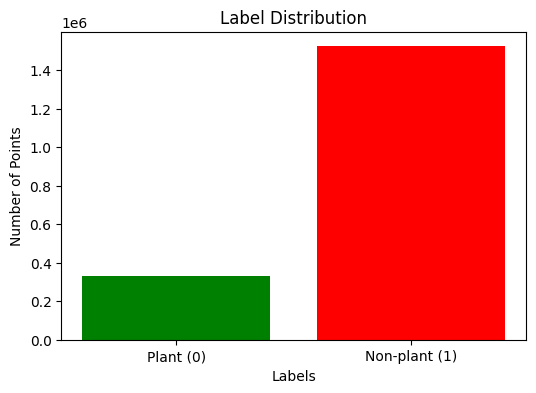

In [116]:
from collections import Counter
# Count the number of plant and non-plant points
label_counts = Counter(labels)
print(f"Plant points (0): {label_counts[0]}")
print(f"Non-plant points (1): {label_counts[1]}")

# Visualize the label distribution
labels_list = labels.tolist()
plt.figure(figsize=(6, 4))
plt.bar(['Plant (0)', 'Non-plant (1)'], [label_counts[0], label_counts[1]], color=['green', 'red'])
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Number of Points')
plt.show()